# **DPP - Progetto**

"In this paper, we model a social network as a simple graph G = (V, E, L, *L*), where V is a set of vertices, E ⊆ V × V is a set of edges, L is a set of labels, and a labeling function *L* : V → L assigns each vertex a label. [...] To keep our discussion simple, we assume that edges do not carry labels. [...]     
The items in the label set L form a hierarchy. For example, if occupations are used as labels of vertices in a social network, L contains not only the specific occupations such as dentist, general physician, optometrist, high school teacher, and primary school teacher, but also general categories like medical doctor, teacher, and professional. We assume that there exists a meta symbol ∗ ∈ L which is the most general category generalizing all labels. For two labels l1, l2 ∈ L, if l1 is more general than l2, we write l1 ≺ l2. For example, medical doctor ≺ optometrist. Moreover, l1 ≺= l2 if and only if l1 ≺ l2 or l1 = l2. ≺= is a partial order on L."  

In [190]:
# ORIGINAL GRAPH TO PROTECT
import networkx as nx

# synthetic undirected graph generation
n = 100
m = 5
G = nx.barabasi_albert_graph(n=n, m=m, seed=42)
print(f"Number of nodes : {len(G.nodes())}")
print(f"Number of edges : {len(G.edges())}")

# importazione di un grafo reale (social network)

Number of nodes : 100
Number of edges : 475


In [191]:
# label domain class definition 
class LabelDomain():
    def __init__(self, labels, children, root):
        self.labels = labels
        self.root = root
        self.children = children # dict mapping node to children
        self.parent = self._build_parent_map()

    def _build_parent_map(self):
        parent = {self.root: None}
        for p, children in self.children.items():
            for c in children:
                parent[c] = p
        return parent

    def size(self, l):
        if not self.children[l]:
            return 1 # it's a leaf
        
        # Recursive case: sum leaf counts of all children
        return sum(self.size(child_label) for child_label in self.children[l])
    
    def is_leaf(self, l):
        return not self.children[l] # no children

    def normalized_certainty_penalty(self, l): # from 0 (a leaf, max certainty) to 1 (most general label, min certainty)
        return self.size(l) / self.size(self.root)
    
    def find_label_common_parent(self, l1, l2):
        if l1 not in self.labels or l2 not in self.labels:
            return None

        ancestors = []
        current = l1

        # Traverse from l1 up to the root
        while current != '*':
            ancestors.append(current)
            current = self.parent[current]

        ancestors.append('*')

        # Traverse from l2 up to the first common label found
        current = l2
        while current != '*':
            if current in ancestors:
                return current
            current = self.parent[current]

        # If no match is found, return the root
        return '*'

In [192]:
# plain toy dict of children
children = {
    # root 
    "*": ["Medical Doctor", "Teacher"],
    # depth 1
    "Medical Doctor": ["Dentist", "General Physician", "Optometrist"],
    "Teacher": ["High School Teacher", "Primary School Teacher"],
    # depth 2
    "Dentist": [],
    "General Physician": [],
    "Optometrist": [],
    "High School Teacher": [],
    "Primary School Teacher": []
}

# set
labels = set(children.keys())
root = "*"

label_domain = LabelDomain(labels, children, "*") # the root is always the * symbol

As reported in the paper, two main properties are recurrent in social networks:   
- **Property 1.** vertex degree in power law distribution
- **Property 2.** the "small-world phenomenon"     

Are those satisfied in our networks?

In [193]:
import random

# Assign random labels to leaves with a fixed seed
def assign_randomly_leaf_labels(G, label_domain, seed=None):
    if seed is not None:
        random.seed(seed)  # set the seed for reproducibility
    
    G.graph['labels'] = label_domain.labels 
    leaf_labels = [l for l in label_domain.children if not label_domain.children[l]]  # all leaves
    
    for node in G.nodes():
        G.nodes[node]['label'] = random.choice(leaf_labels)
    
    return G

# Example usage:
G = assign_randomly_leaf_labels(G, label_domain, seed=42)

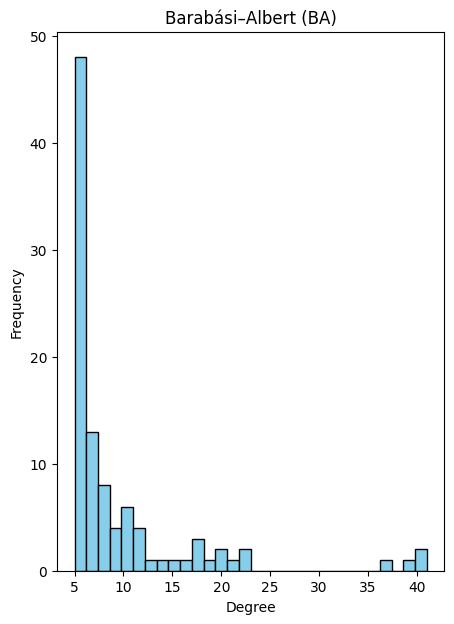

Average diameter:  2.16969696969697


In [194]:
import matplotlib.pyplot as plt

# plot the degree distribution of the networks
plt.figure(figsize=(5, 7))
plt.title("Barabási–Albert (BA)")
degrees_ba = [d for n, d in G.degree()]
plt.hist(degrees_ba, bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# compute the average diameter of the network
avg_path_length = nx.average_shortest_path_length(G)
print("Average diameter: ", avg_path_length)

Both properties are satisfied. 

## Anonymization algorithm implementation    

In [195]:
# -1: e1 < e2
# 0: e1 = e2
# 1: e1 > e2
def compareEdges(e1, e2, dfs_time, dfs_edges):
    u1, v1 = sorted(e1)
    u2, v2 = sorted(e2)
    i1, j1 = dfs_time[u1], dfs_time[v1]
    i2, j2 = dfs_time[u2], dfs_time[v2]
    forward1 = dfs_edges[(u1, v1)]
    forward2 = dfs_edges[(u2, v2)]

    # Rule 1
    if forward1 and forward2:
        if j1 < j2: return -1
        elif j1 > j2: return 1
        elif i1 > i2: return -1
        elif i1 < i2: return 1
        else: return 0

    # Rule 2
    if not forward1 and not forward2:
        if i1 < i2: return -1
        elif i1 > i2: return 1
        elif j1 < j2: return -1
        elif j1 > j2: return 1
        else: return 0

    # Rule 3
    if forward1 and not forward2:
        return -1 if j1 <= i2 else 1

    # Rule 4
    if not forward1 and forward2:
        return -1 if i1 < j2 else 1
    
def make_compare_edges(dfs_time, mark_edges):
    # This returns a function that only takes e1, e2
    def compare(e1, e2):
        return compareEdges(e1, e2, dfs_time, mark_edges)
    return compare

In [196]:
'''
def dfs(G: nx.Graph):
    tick = [0]  # mutable counter, for proper update with many recursions 
    visited = set()
    dfs_time = {}
    dfs_edges = {}

    for u, v in G.edges():
         dfs_edges[tuple(sorted([u, v]))] = False # default: backward edges
    for node in sorted(G.nodes()):
        if node not in visited:
            dfs_visit(G, node, tick, dfs_time, visited, dfs_edges)
    
    return dfs_time, dfs_edges
'''

def dfs_visit(G: nx.Graph, node: int, tick: list, dfs_time: dict, visited: set, dfs_edges: dict):
    visited.add(node)
    tick[0] += 1
    dfs_time[node] = tick[0]
    for neighbor in sorted(G.neighbors(node)):
        if neighbor not in visited:
            dfs_edges[tuple(sorted([node, neighbor]))] = True
            dfs_visit(G, neighbor, tick, dfs_time, visited, dfs_edges)

from functools import cmp_to_key

def get_dfs_code_for_root(G, start_node):
    # Esegui la visita DFS partendo ESCLUSIVAMENTE da start_node
    # Nota: Assumiamo che G sia connesso (è un componente)
    tick = [0]
    visited = set()
    dfs_time = {}
    dfs_edges = {}
    
    # Inizializza edges come backward
    for u, v in G.edges():
         dfs_edges[tuple(sorted([u, v]))] = False 

    # Lancia la visita solo dalla root scelta
    dfs_visit(G, start_node, tick, dfs_time, visited, dfs_edges)
    
    # Genera il codice per questa specifica visita
    make_cmp = make_compare_edges(dfs_time, dfs_edges)
    EdgeList = [tuple(sorted(e)) for e in G.edges()]
    EdgeList_sorted = sorted(EdgeList, key=cmp_to_key(make_cmp))
    
    code = []
    for u, v in EdgeList_sorted:
        label_u = G.nodes[u]['label']
        label_v = G.nodes[v]['label']
        # Usiamo una tupla comparabile lessicograficamente
        code.append((dfs_time[u], dfs_time[v], label_u, label_v))
        
    # Gestione nodo singolo
    if not code and len(G.nodes()) == 1:
        u = next(iter(G.nodes()))
        label_u = G.nodes[u]['label']
        code.append((1, 1, label_u, None)) # Formato fittizio per comparazione
        
    return code

def minimumDFScode(G: nx.Graph):
    if not G.nodes():
        return []
    
    best_code = None
    
    for node in G.nodes():
        candidate_code = get_dfs_code_for_root(G, node)
        
        # Confronto lessicografico standard delle liste di tuple
        if best_code is None or candidate_code < best_code:
            best_code = candidate_code
            
    return best_code

In [197]:
def bfs_order(subgraph: nx.Graph, start: int) -> list:
    visited = set()
    queue = [start] 
    order = []

    while queue:
        node = queue.pop(0)
        if node not in visited:
            visited.add(node)
            order.append(node)
            for neighbor in sorted(subgraph.neighbors(node)): 
                if neighbor not in visited and neighbor not in queue:
                    queue.append(neighbor)

    return order

In [198]:
# Nu1, Nv1: original neighborhood of u and v, respectively
# Nu2, Nv2: anonymized neighborhood of u and v, respectively

def anonymizazion_cost(Nu1: nx.Graph, Nv1: nx.Graph, Nu2: nx.Graph, Nv2: nx.Graph, label_domain: LabelDomain, alpha: float, beta: float, gamma: float) -> float:

    H1 = nx.compose(Nu1, Nv1)
    H2 = nx.compose(Nu2, Nv2)

    # first contribution
    ncp_cost = sum(label_domain.normalized_certainty_penalty(H2.nodes[n]['label']) for n in H2.nodes())
    ncp_cost *= alpha

    # second contribution
    added_edges = [(v1, v2) for v1, v2 in H2.edges() if not H1.has_edge(v1, v2)]
    edge_cost = beta * len(added_edges)

    # third contribution
    vertex_cost = gamma * (len(H2.nodes()) - len(H1.nodes()))

    return ncp_cost + edge_cost + vertex_cost

In [199]:
def choose_starting_matching_nodes(c_u: nx.Graph, c_v: nx.Graph, label_domain: LabelDomain) -> tuple[int, int]:  # deterministic & tested
    degree_label_candidate_pair = None
    max_degree = -1

    # Step 1: degree-label matches
    for x in sorted(c_u.nodes()): # sort for determinism
        label_x = c_u.nodes[x]['label']
        deg_x = c_u.degree[x]
        
        for y in sorted(c_v.nodes()): # sort for determinism
            label_y = c_v.nodes[y]['label']
            deg_y = c_v.degree[y]
            
            if deg_x == deg_y and label_x == label_y:
                if deg_x > max_degree or (deg_x == max_degree and (x, y) < degree_label_candidate_pair):  # last < for determinism
                    degree_label_candidate_pair = (x, y)
                    max_degree = deg_x

    if degree_label_candidate_pair:
        return degree_label_candidate_pair
    
    # Step 2: fallback - compute anonymization cost
    min_cost = float('inf')
    cost_candidate_pair = None

    for x in sorted(c_u.nodes()): # sort for determinism
        label_x = c_u.nodes[x]['label']
        deg_x = c_u.degree[x]

        for y in sorted(c_v.nodes()): # sort for determinism
            label_y = c_v.nodes[y]['label']
            deg_y = c_v.degree[y]

            general_label = label_domain.find_label_common_parent(label_x, label_y)
            cost = abs(deg_x - deg_y) + label_domain.normalized_certainty_penalty(general_label)
            # Update candidate pair if cost is smaller, or tie-break lexicographically
            if cost < min_cost or (cost == min_cost and (x, y) < cost_candidate_pair): # last < for determinism
                min_cost = cost
                cost_candidate_pair = (x, y)

    return cost_candidate_pair

In [200]:
def neighborhood_size_key(G, v):
    neighbors = list(G.neighbors(v))
    sub_nodes = [v] + neighbors
    subgraph = G.subgraph(sub_nodes)
    
    num_vertices = subgraph.number_of_nodes()
    num_edges = subgraph.number_of_edges()

    return (num_vertices, num_edges, v) # using v at the end make it deterministic

In [201]:
# Assume the following are true before calling the function:
# - node_map_1_2 and node_map_2_1 are:
#      - total (every node is mapped),
#      - bijective,
#      - inverses of each other.
# - comp1 and comp2 have the same number of nodes.
# - both are simple graphs (no multiedges, no direction).

def make_components_isomoprhic(comp1: nx.Graph, comp2: nx.Graph, node_map_1_2: dict, node_map_2_1: dict, label_domain: LabelDomain):
    
    comp1_anon, comp2_anon = comp1.copy(), comp2.copy()

    # Step 1: Generalize labels
    for n1, n2 in node_map_1_2.items():

        label1 = comp1_anon.nodes[n1]['label']
        label2 = comp2_anon.nodes[n2]['label']

        general_label = label_domain.find_label_common_parent(label1, label2)

        comp1_anon.nodes[n1]['label'] = general_label
        comp2_anon.nodes[n2]['label'] = general_label

    # shared nodes problem: (9, 22), (43, 9) -> 9 will get a label1 in comp1 and a label1 in comp2 and label1 might be different from label2
    shared_nodes = set(comp1_anon.nodes()).intersection(comp2_anon.nodes())
    for node in shared_nodes:
        label1 = comp1_anon.nodes[node]['label']
        label2 = comp2_anon.nodes[node]['label']
        
        general_label = label_domain.find_label_common_parent(label1, label2)
        
        comp1_anon.nodes[node]['label'] = general_label
        comp2_anon.nodes[node]['label'] = general_label

        #update the associated nodes
        comp1_anon.nodes[node_map_2_1[node]]['label'] = general_label
        comp2_anon.nodes[node_map_1_2[node]]['label'] = general_label

    # Step 2: Equalize neighborhoods
    for (w, z) in comp1_anon.edges():
        if not comp2_anon.has_edge(node_map_1_2[w], node_map_1_2[z]):
            comp2_anon.add_edge(node_map_1_2[w], node_map_1_2[z])

    for (w, z) in comp2_anon.edges():
        if not comp1_anon.has_edge(node_map_2_1[w], node_map_2_1[z]):
            comp1_anon.add_edge(node_map_2_1[w], node_map_2_1[z])

    return comp1_anon, comp2_anon

In [202]:
def find_missing_matching_vertex(G: nx.Graph, s: int, anonymized: dict, constraints: list, label_domain: LabelDomain)-> int:
    
    unanon_nodes = sorted(n for n, v in anonymized.items() if not v and n not in constraints) # deterministic

    if unanon_nodes:
        search_space = unanon_nodes
    else:
        search_space = sorted(n for n in G.nodes() if n not in constraints) # deterministic

    deg_dict = {n: G.degree(n) for n in search_space}
    min_deg = min(deg_dict.values())

    min_deg_nodes = sorted(n for n, d in deg_dict.items() if d == min_deg) # deterministic

    best_cost = float('inf')
    best_nodes = []

    for node in min_deg_nodes:
        general_label = label_domain.find_label_common_parent(G.nodes[node]['label'], G.nodes[s]['label'])
        cost = label_domain.normalized_certainty_penalty(general_label)

        if cost < best_cost:
            best_cost = cost
            best_nodes = [node]
        elif cost == best_cost:
            best_nodes.append(node)

    # deterministic tie-breaker
    return min(best_nodes)

In [203]:
# generalize the two centers labels
def generalize_labels(G: nx.Graph, u: int, v: int, label_domain: LabelDomain):
    label_u = G.nodes[u]['label']
    label_v = G.nodes[v]['label']
    general_label = label_domain.find_label_common_parent(label_u, label_v)
    G.nodes[u]['label'] = general_label 
    G.nodes[v]['label'] = general_label


In [204]:
# Remaining elements
# the new vertex cannot be equal to:
# - one in the neighborhood of the node in general -> they may have been already matched and i make change the components structure
# - the node itself
# - the previous external added nodes -> cannot count them twice
# - neither one of the current equality class -> equality class would break
# - the neighbors of the nodes in the equality class already anonymized (if label changes I'm dead, is it not isomoprhich anymore with the others)

def build_constraints(G: nx.Graph, center: int, eq_class: list[int], anonymized: dict, *extra_constraints: set[int]) -> set[int]: # tested & deterministic
    constraints = {center}
    #constraints = set()
    #for node in eq_class:
    #    if anonymized[node]:
    #        constraints.add(node)
    #constraints.update(G.neighbors(center))
    for s in extra_constraints:
        constraints.update(s)

    return constraints

In [205]:
def build_component(G: nx.Graph, ref_comp: nx.Graph, ref_node: int, src_node: int, EquivalenceClassDict: dict, label_domain: LabelDomain) -> tuple[nx.Graph, nx.Graph, dict]: 
    # tested & deterministic

    node_map_1_2 = {}
    node_map_2_1 = {}
    anonymized = {n: data['anonymized'] for n, data in G.nodes(data=True)}

    for ref_node_in_comp in sorted(ref_comp.nodes()):
        print(f"Finding a match for node {ref_node_in_comp}")
        
        # Build constraints to find a valid match in the graph
        constraints = build_constraints(G, src_node, EquivalenceClassDict[src_node], anonymized, set(node_map_2_1.keys())) 
        print(f"Built constraints: {constraints}")
        
        new_vertex = find_missing_matching_vertex(G, ref_node_in_comp, anonymized, constraints, label_domain)

        if new_vertex is None:
            print("Empty vertex - Error: Could not find a suitable vertex to add.")
            # In a real scenario, you might need to handle this (e.g., fallback or heuristic), 
            # but assuming the paper's greedy approach always finds something or uses a 'dummy'.
        else:
            print(f"New vertex found in build_component: {new_vertex} matching {ref_node_in_comp}")

        # If we picked a node that was previously anonymized, we must "break" its group
        # (This logic is handled here locally for constraints, and globally in the main loop via Ripple Effect)
        if anonymized.get(new_vertex):
            for eq_node in EquivalenceClassDict.get(new_vertex, []):
                anonymized[eq_node] = False

        node_map_1_2[ref_node_in_comp] = new_vertex
        node_map_2_1[new_vertex] = ref_node_in_comp

    # Construct the source component based on the found vertices
    src_comp = G.subgraph(node_map_2_1.keys())

    print("node_map_1_2: ", node_map_1_2)
    # print("node_map_2_1: ", node_map_2_1)
    
    # Make them isomorphic (add edges, generalize labels)
    ref_comp_anon, src_comp_anon = make_components_isomoprhic(ref_comp, src_comp, node_map_1_2, node_map_2_1, label_domain)

    # RETURN the mapping (ref_comp_nodes -> src_comp_nodes)
    return ref_comp_anon, src_comp_anon, node_map_1_2

In [206]:
def match_and_generalize_components(G: nx.Graph, comp1: nx.Graph, comp2: nx.Graph, c1: int, c2: int, EquivalenceClassDict, label_domain: LabelDomain) -> tuple[nx.Graph, nx.Graph, dict]: 
    # tested & deterministic

    # we are simulating, i only modify anonymized label in the simulation
    anonymized = {n: data['anonymized'] for n, data in G.nodes(data=True)} 

    (s1, s2) = choose_starting_matching_nodes(comp1, comp2, label_domain)
    
    order1, order2 = bfs_order(comp1, s1), bfs_order(comp2, s2)

    node_map_1_2 = {}
    node_map_2_1 = {}

    min_len = min(len(order1), len(order2))

    # 1. Match existing nodes by BFS order
    for i in range(min_len):
        n1 = order1[i]
        n2 = order2[i]
        node_map_1_2[n1] = n2
        node_map_2_1[n2] = n1

    # 2. Handle nodes in comp1 that have no match in comp2 (add external node to comp2)
    for n1 in order1[min_len:]:
        # print(f"Finding a match for node {n1}")
        constraints = build_constraints(G, c2, EquivalenceClassDict[c2], anonymized, set(node_map_2_1.keys()))
        
        new_vertex = find_missing_matching_vertex(G, n1, anonymized, constraints, label_domain)

        if anonymized[new_vertex]:
            for node in EquivalenceClassDict[new_vertex]:
                anonymized[node] = False

        node_map_1_2[n1] = new_vertex
        node_map_2_1[new_vertex] = n1

    # 3. Handle nodes in comp2 that have no match in comp1 (add external node to comp1)
    for n2 in order2[min_len:]:
        # print(f"Finding a match for node {n2}")
        constraints = build_constraints(G, c1, EquivalenceClassDict[c1], anonymized, set(node_map_1_2.keys()))
        
        new_vertex = find_missing_matching_vertex(G, n2, anonymized, constraints, label_domain)

        if anonymized[new_vertex]:
            for node in EquivalenceClassDict[new_vertex]:
                anonymized[node] = False

        # Note: new_vertex is added to comp1, n2 is in comp2.
        # So we map new_vertex (in comp1) -> n2 (in comp2)
        node_map_1_2[new_vertex] = n2
        node_map_2_1[n2] = new_vertex

    # 4. Create Anonymized Copies
    # We use the keys of the maps to define the subgraphs, as they now contain 
    # both original nodes and the newly found 'missing' vertices.
    comp1_nodes = list(node_map_1_2.keys())
    comp2_nodes = list(node_map_2_1.keys())
    
    sub_c1 = G.subgraph(comp1_nodes)
    sub_c2 = G.subgraph(comp2_nodes)
    
    comp1_anon, comp2_anon = make_components_isomoprhic(sub_c1, sub_c2, node_map_1_2, node_map_2_1, label_domain)

    # Return the graphs AND the mapping (comp1 -> comp2)
    return comp1_anon, comp2_anon, node_map_1_2

In [207]:
def most_similar_component(G, ref_comp_id: int, component_graphs: dict, unmatched_component_ids: set[int], ref_node,
    src_node, EquivalenceClassDict, label_domain, alpha, beta, gamma) -> tuple[int, nx.Graph, nx.Graph, dict]:

    best_cost = float('inf')
    most_similar_id = float('inf')
    best_ref_anon = None
    best_unm_anon = None
    best_mapping = {} # <--- Store the mapping of the best candidate
    
    # Deterministic ordering of IDs
    sorted_unmatched_ids = sorted(unmatched_component_ids)
    
    # The reference component subgraph
    ref_comp = component_graphs[ref_node][ref_comp_id]

    for unm_id in sorted_unmatched_ids:
        unm_comp = component_graphs[src_node][unm_id]

        # --- IMPORTANT ---
        # match_and_generalize_components determines how nodes align.
        # It must return this alignment (mapping) so we can sync changes later.
        ref_anon, unm_anon, current_mapping = match_and_generalize_components(
            G, ref_comp, unm_comp, ref_node, src_node, EquivalenceClassDict, label_domain
        )

        cost = anonymizazion_cost(ref_comp, unm_comp, ref_anon, unm_anon, label_domain, alpha, beta, gamma)

        # Deterministic tie-breaker
        if cost < best_cost or (cost == best_cost and unm_id < most_similar_id):
            best_cost = cost
            best_ref_anon = ref_anon
            best_unm_anon = unm_anon
            most_similar_id = unm_id
            best_mapping = current_mapping # <--- Save the mapping associated with this cost

    return most_similar_id, best_ref_anon, best_unm_anon, best_mapping

In [208]:
def get_neighborhood_components(G: nx.Graph, u: int, v: int): # deterministic

    # Neighborhood subgraphs
    Nu = G.subgraph(sorted(G.neighbors(u))).copy()
    Nv = G.subgraph(sorted(G.neighbors(v))).copy()

    # Connected components of the neighborhoods
    Cu = [sorted(c) for c in nx.connected_components(Nu)]
    Cv = [sorted(c) for c in nx.connected_components(Nv)]

    # Sort components by smallest node ID (deterministic ordering)
    Cu.sort(key=lambda nodes: nodes[0] if nodes else float('inf'))
    Cv.sort(key=lambda nodes: nodes[0] if nodes else float('inf'))

    print(f"Number of components node {u}: {len(Cu)}")
    print(f"Number of components node {v}: {len(Cv)}")

    # Build component subgraphs with deterministic IDs
    component_graphs = {
        u: {i: Nu.subgraph(nodes).copy() for i, nodes in enumerate(Cu)},
        v: {i: Nv.subgraph(nodes).copy() for i, nodes in enumerate(Cv)}
    }

    unmatched_components = {
        u: set(component_graphs[u].keys()),
        v: set(component_graphs[v].keys())
    }

    return component_graphs, unmatched_components

In [209]:
def update_graph(G: nx.Graph, c_u_anon: nx.Graph, c_v_anon: nx.Graph, u: int, v: int): # deterministic & tested

    G.add_nodes_from(c_u_anon.nodes(data=True))  # include attributes
    G.add_edges_from(c_u_anon.edges(data=True))  # include attributes
    for node in c_u_anon:
        G.add_edge(u, node) # if i added a vertex to a component, this link is missing

    G.add_nodes_from(c_v_anon.nodes(data=True))  # include attributes
    G.add_edges_from(c_v_anon.edges(data=True))  # include attributes
    for node in c_v_anon:
        G.add_edge(v, node)

In [210]:
from networkx.algorithms import isomorphism

def find_perfect_comp_matches(u, v, component_graphs, unmatched_components):
    """
    Finds components with identical minimum DFS codes and calculates 
    the node-to-node mapping between them.
    """
    perfect_mapping = {}
    
    # We need to iterate over a copy or lookups because we modify the lists
    # However, the original code loops over sorted IDs and removes them from a dict/list reference.
    # To be safe, we collect matches first, then remove.
    matches_found = [] # List of (cu_id, cv_id)

    # Helper for node matching based on labels (required for correct mapping)
    # Assumes your nodes have a 'label' attribute
    node_matcher = isomorphism.categorical_node_match('label', None)

    for cu_id in sorted(unmatched_components[u]):
        c_u = component_graphs[u][cu_id]
        matched_cv_id = None
        
        for cv_id in sorted(unmatched_components[v]):
            # Skip if this cv_id was already matched in this function call
            if cv_id in [m[1] for m in matches_found]:
                continue

            c_v = component_graphs[v][cv_id]
            
            # 1. Fast check using DFS Codes
            if minimumDFScode(c_u) == minimumDFScode(c_v):
                matched_cv_id = cv_id
                
                # 2. Recover the mapping using NetworkX
                # We know they are isomorphic, but we need the dictionary {node_u: node_v}
                gm = isomorphism.GraphMatcher(c_u, c_v, node_match=node_matcher)
                
                if gm.is_isomorphic():
                    # gm.mapping returns {node_in_cu: node_in_cv}
                    perfect_mapping.update(gm.mapping)
                    matches_found.append((cu_id, cv_id))
                    
                    print("1 perfect component match!")
                    print(f"Matched: {list(c_u.nodes)} - {list(c_v.nodes)}")
                    break # Stop looking for matches for this cu_id

    # Remove matched components from the sets/lists
    for cu_id, cv_id in matches_found:
        unmatched_components[u].remove(cu_id)
        unmatched_components[v].remove(cv_id)

    return unmatched_components, perfect_mapping

In [211]:
import matplotlib.pyplot as plt

def plot_colored_graph(G, special_nodes, special_color='green', default_color='lightblue'):
    # Start with all nodes as default color
    node_colors = {node: default_color for node in G.nodes()}
    
    # Highlight special nodes and their neighbors
    for node in special_nodes:
        node_colors[node] = special_color
        for neighbor in G.neighbors(node):
            node_colors[neighbor] = special_color
    
    # Get the list of colors in the order of G.nodes()
    colors = [node_colors[node] for node in G.nodes()]
    
    # Draw the graph
    pos = nx.spring_layout(G)  # nice layout
    nx.draw(G, pos, with_labels=True, node_color=colors, edge_color='gray', node_size=800)
    plt.show()

def plot_component(comp, title="Component"):
    pos = nx.spring_layout(comp, seed=42)  # deterministic layout
    plt.figure(figsize=(6, 6))
    
    # Draw nodes
    nx.draw_networkx_nodes(comp, pos, node_color='skyblue', node_size=600, alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(comp, pos, width=1.5, alpha=0.7)
    
    # Draw labels: show node id and node label
    node_labels = {n: f"{n}\n{comp.nodes[n]['label']}" for n in comp.nodes()}
    nx.draw_networkx_labels(comp, pos, labels=node_labels, font_size=10, font_color='black')
    
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()


In [212]:
def anonymized_nodes_with_changes(G_before: nx.Graph, G_after: nx.Graph):
    changed_nodes = set()

    # old nodes modified
    for node in G_before.nodes():
        if G_before.nodes[node]['anonymized']:
            # Check label change
            label_before = G_before.nodes[node]['label']
            label_after  = G_after.nodes[node]['label']
            label_changed = (label_before != label_after)

            # Check neighbors change
            neighbors_before = set(G_before.neighbors(node))
            neighbors_after  = set(G_after.neighbors(node))
            neighbors_changed = (neighbors_before != neighbors_after)

            if label_changed or neighbors_changed:
                changed_nodes.add(node)

    # new nodes
    for node in set(G_after.nodes()) - set(G_before.nodes()):
        if G_after.nodes[node]['anonymized']:
            changed_nodes.add(node)

    return changed_nodes

In [213]:
def process_modified_anonymized_nodes(
    G: nx.Graph,
    added_anon_nodes: list,
    EquivalenceClassDict: dict,
    VertexList: list,
    neighborhood_size_key):
    processed_classes = []

    for added_anon in added_anon_nodes:
        # Skip nodes that are already in a processed equivalence class
        skip = False
        for processed_class in processed_classes:
            if added_anon in processed_class:
                skip = True
                break
        if skip:
            continue

        # Get the equivalence class for this node
        eq_class_nodes = EquivalenceClassDict[added_anon]

        # Track this class to avoid duplicate processing
        processed_classes.append(eq_class_nodes)

        # Reset 'anonymized' flags for the class
        for n in eq_class_nodes:
            G.nodes[n]['anonymized'] = False

        # Extend and sort the VertexList
        VertexList.extend(eq_class_nodes)
        VertexList.sort(key=lambda v: neighborhood_size_key(G, v))

        # Remove processed nodes from EquivalenceClassDict
        for n in eq_class_nodes:
            if n in EquivalenceClassDict:
                del EquivalenceClassDict[n]


In [214]:
def sync_group_changes(G, current_group, seed, changes, group_mappings):
    """
    Propagates changes made to the Seed's neighborhood to all other 
    currently processed members of the equivalence class.
    
    Args:
        G: The networkx Graph
        current_group: List of nodes [Seed, Member1, Member2...]
        seed: The ID of the seed node
        changes: List of change dicts returned by anonymize_pair
                 e.g. [{'type': 'add_edge', 'u': 10, 'v': 12}, ...]
                 (Note: 'u' and 'v' refer to nodes in Seed's neighborhood)
        group_mappings: Dict of {member_id: {seed_neighbor_id: member_neighbor_id}}
    """
    
    # Helper to find the corresponding node in a member's neighborhood
    def resolve_node(node_id, member_id):
        # 1. If the node is the Seed itself, the counterpart is the Member itself
        if node_id == seed:
            return member_id
            
        # 2. Check if the node is mapped within the neighborhood
        mapping = group_mappings.get(member_id, {})
        if node_id in mapping:
            return mapping[node_id]
            
        # 3. If node is not in mapping, it is an "external" node introduced
        # during the process (e.g., a node outside the neighborhood linked to help anonymize).
        # In this case, the Member connects to the exact same external node.
        return node_id

    # Apply changes to every other member in the group
    for member in current_group:
        if member == seed:
            continue
            
        # We only sync members that have ALREADY been mapped/processed.
        # (If member isn't in group_mappings, it's the one we just processed 
        # or hasn't been processed yet, so no need to sync).
        if member not in group_mappings:
            continue

        for change in changes:
            if change['type'] == 'add_edge':
                # The change says: Edge added between u and v in Seed's view.
                u_seed = change['u']
                v_seed = change['v']
                
                # Find u and v from Member's perspective
                u_mem = resolve_node(u_seed, member)
                v_mem = resolve_node(v_seed, member)
                
                # Apply change
                if u_mem != v_mem and not G.has_edge(u_mem, v_mem):
                    G.add_edge(u_mem, v_mem)
                    # Note: We don't add to 'changes' recursively here.
                    
            elif change['type'] == 'update_label':
                # The change says: Node u in Seed's view got label L
                u_seed = change['u']
                new_label = change['label']
                
                u_mem = resolve_node(u_seed, member)
                
                # Apply change
                G.nodes[u_mem]['label'] = new_label

    return

In [215]:
def anonymize_pair(G: nx.Graph, u: int, v: int, label_domain: LabelDomain, EquivalenceClassDict: dict, alpha: float, beta: float, gamma: float) -> tuple[list, dict]:

    # 1. Initialize Tracking
    mapping = {u: v} # The centers always map to each other
    changes = []

    # Snapshot of u's neighborhood state before changes
    # set(G.neighbors(u)) creates a copy, so .copy() is technically redundant but safe
    original_u_nodes = set(G.neighbors(u))
    # Edges needs explicit copy or list conversion to freeze state
    original_u_edges = set(G.subgraph(list(original_u_nodes) + [u]).edges())
    original_labels = {n: G.nodes[n]['label'] for n in list(original_u_nodes) + [u]}

    # Get neighborhood components
    component_graphs, unmatched_components = get_neighborhood_components(G, u, v)
    
    # Perfect Matches
    unmatched_components, perfect_mapping = find_perfect_comp_matches(u, v, component_graphs, unmatched_components)
    mapping.update(perfect_mapping)

    while unmatched_components[u] and unmatched_components[v]:
        largest_u_id = max(unmatched_components[u], key=lambda cid: len(component_graphs[u][cid]))
        largest_v_id = max(unmatched_components[v], key=lambda cid: len(component_graphs[v][cid]))
        
        largest_u_component = component_graphs[u][largest_u_id]
        largest_v_component = component_graphs[v][largest_v_id]

        # Determine Source/Target based on size
        if len(largest_u_component) >= len(largest_v_component):
            target, source = u, v
            target_cid, source_cid = largest_u_id, largest_v_id
        else:
            target, source = v, u
            target_cid, source_cid = largest_v_id, largest_u_id

        # local_mapping is ALWAYS: Node_in_Target -> Node_in_Source
        most_sim_id, target_anon_g, source_anon_g, local_mapping = most_similar_component(
                G, target_cid, component_graphs, unmatched_components[source],
                ref_node=target, src_node=source,
                EquivalenceClassDict=EquivalenceClassDict, 
                label_domain=label_domain,
                alpha=alpha, beta=beta, gamma=gamma
        )

        # Update global mapping: Must be Node_in_u -> Node_in_v
        if source == v:
            # Target is u, Source is v. 
            # local_mapping is u_node -> v_node. This is what we want.
            # local_mapping.items() gives (u_node, v_node)
            for target_node, source_node in local_mapping.items():
                mapping[target_node] = source_node
        else:
            # Target is v, Source is u.
            # local_mapping is v_node -> u_node.
            # We must INVERT this to store u_node -> v_node.
            ### CORRECTION START
            for target_node, source_node in local_mapping.items():
                mapping[source_node] = target_node
            ### CORRECTION END

        update_graph(G, target_anon_g, source_anon_g, target, source)

        unmatched_components[target].remove(target_cid)
        unmatched_components[source].remove(most_sim_id)

    # 5. Orphaned Components
    if unmatched_components[u]:
        target, source, extras = u, v, unmatched_components[u].copy()
    else:
        target, source, extras = v, u, unmatched_components[v].copy()

    for cid in extras:
        extra_comp = component_graphs[target][cid]
        
        # build_component returns mapping: Node_in_Target -> Node_in_Source
        target_anon_g, source_anon_g, local_mapping = build_component(
            G, extra_comp, target, source, EquivalenceClassDict, label_domain
        )
        
        # Update global mapping: Must be Node_in_u -> Node_in_v
        if source == v:
            # Target is u, Source is v. mapping is u->v.
            for target_node, source_node in local_mapping.items():
                mapping[target_node] = source_node
        else:
            # Target is v, Source is u. mapping is v->u.
            ### CORRECTION START
            for target_node, source_node in local_mapping.items():
                mapping[source_node] = target_node
            ### CORRECTION END

        update_graph(G, target_anon_g, source_anon_g, target, source)
        unmatched_components[target].remove(cid)

    # 6. Generalize Center Labels
    generalize_labels(G, u, v, label_domain)

    # 7. Calculate Changes (Delta Detection)
    # This logic is correct.
    current_u_nodes = set(G.neighbors(u))
    
    # Edges added to u
    current_subgraph = G.subgraph(list(current_u_nodes) + [u])
    for e in current_subgraph.edges():
        # Check if edge existed in either direction
        if not (e in original_u_edges or (e[1], e[0]) in original_u_edges):
            changes.append({'type': 'add_edge', 'u': e[0], 'v': e[1]})
            
    # Labels changed in u's neighborhood
    for n in list(current_u_nodes) + [u]:
        new_label = G.nodes[n]['label']
        old_label = original_labels.get(n) # Returns None if n is a new node
        
        # We record change if label is different (and it's not a new node that implicitly has a label)
        # Note: If it's a new node, old_label is None. new_label != None. 
        # This will record an 'update_label' for new nodes too, which is fine/safe.
        if old_label is not None and new_label != old_label:
            changes.append({'type': 'update_label', 'u': n, 'label': new_label})
    
    return changes, mapping

In [216]:
def anonymize_graph(G: nx.Graph, k: int, label_domain: LabelDomain, alpha: float, beta: float, gamma: float)-> nx.Graph:
    
    G_anon = G.copy()
    VertexList = sorted(G_anon.nodes, key=lambda v: neighborhood_size_key(G_anon, v), reverse=True)  # descending order

    EquivalenceClassDict = {}
    nx.set_node_attributes(G_anon, False, 'anonymized')

    while VertexList:
        print("------------------------------")
        print("VertexList: ", VertexList)
        SeedVertex = VertexList.pop(0) # remove and return
        label_seed = G_anon.nodes[SeedVertex]['label']
        deg_seed = G_anon.degree[SeedVertex]

        costs = {}
        for v in VertexList:
            # order by cost based on degree difference + NPC
            label_v = G_anon.nodes[v]['label']
            deg_v = G_anon.degree[v]

            general_label = label_domain.find_label_common_parent(label_seed, label_v)
            costs[v] = abs(deg_seed - deg_v) + label_domain.normalized_certainty_penalty(general_label)

        # select candidate set
        if len(VertexList) >= (2*k - 1):
            sorted_cost = sorted(costs.items(), key=lambda item: item[1])
            candidate_set = [node for node, _ in sorted_cost[:k-1]]

        else: 
            candidate_set = VertexList.copy() # otherwise if i remove a node from VertexList is remove also from candidate_set

        for v in [SeedVertex] + candidate_set:
            EquivalenceClassDict[v] = [SeedVertex] + candidate_set

        print("K: ", k)
        print("candidate_set: ", candidate_set)
        print("SeedVertex: ", SeedVertex)
        group_mappings = {} 
        current_group = [SeedVertex] + candidate_set

        # i need to incrementally improve G_anon
        for j in range(1, len(current_group)):
            uj = current_group[j]
            
            # Anonymize uj against Seed
            # Note: We pass EquivalenceClassDict only if logic needs to know groups, 
            # but usually changes/mapping return is sufficient.
            changes, mapping = anonymize_pair(G_anon, SeedVertex, uj, label_domain, EquivalenceClassDict, alpha, beta, gamma)
            
            group_mappings[uj] = mapping
            
            # Propagate changes to other members (Seed, u1... uj-1)
            sync_group_changes(G_anon, current_group, SeedVertex, changes, group_mappings)
            
            # --- CRITICAL: HANDLE RIPPLE EFFECT ---
            # Identify external nodes touched by changes
            touched_nodes = set()
            for c in changes:
                touched_nodes.add(c['u'])
                if 'v' in c: touched_nodes.add(c['v'])
            
            for node in touched_nodes:
                if node not in current_group:
                    # If we touched an external node that was already finalized
                    if G_anon.nodes[node].get('anonymized') == True:
                        print(f"Ripple: Breaking group of {node}")
                        broken_group = EquivalenceClassDict.get(node, [node])
                        for member in broken_group:
                            # Mark as unanonymized
                            G_anon.nodes[member]['anonymized'] = False
                            # Re-insert into VertexList if not present
                            if member not in VertexList:
                                VertexList.append(member)
        
        # --- FINALIZE GROUP ---
        for node in current_group:
            G_anon.nodes[node]['anonymized'] = True
            # Remove from VertexList if present
            if node in VertexList:
                VertexList.remove(node)

        # Re-sort list as neighborhood sizes might have changed
        VertexList.sort(key=lambda v: neighborhood_size_key(G_anon, v), reverse=True)

    return G_anon

In [217]:
import networkx as nx
from networkx.algorithms import isomorphism

def check_isomorphic_classes(G: nx.Graph, EquivalenceClassDict):
    """
    Given a graph G and a dictionary mapping node -> equivalence class nodes,
    return a mapping of class_id -> list of lists of truly isomorphic nodes.
    """

    processed_classes = set()  # track already-processed equivalence classes
    iso_class_result = []      # list of lists of nodes that are isomorphic

    for node, eq_class_nodes in EquivalenceClassDict.items():
        # Skip if already processed (same list)
        class_id = tuple(sorted(eq_class_nodes))  # canonical representation
        if class_id in processed_classes:
            continue
        processed_classes.add(class_id)

        # Start with first node as reference
        subgraphs_by_iso = []  # each element is a list of nodes isomorphic to each other
        reference_node = eq_class_nodes[0]
        reference_subgraph = G.subgraph([reference_node] + list(G.neighbors(reference_node))).copy()
        current_iso_group = [reference_node]

        for n in eq_class_nodes[1:]:
            subG = G.subgraph([n] + list(G.neighbors(n))).copy()

            # Use GraphMatcher to check isomorphism
            GM = isomorphism.GraphMatcher(reference_subgraph, subG,
                                          node_match=isomorphism.categorical_node_match('label', None),
                                          edge_match=isomorphism.categorical_edge_match('label', None))
            if GM.is_isomorphic():
                current_iso_group.append(n)
            else:
                # start a new iso group with this node as reference
                subgraphs_by_iso.append(current_iso_group)
                reference_subgraph = subG
                current_iso_group = [n]

        # append last group
        subgraphs_by_iso.append(current_iso_group)

        iso_class_result.extend(subgraphs_by_iso)

    return iso_class_result

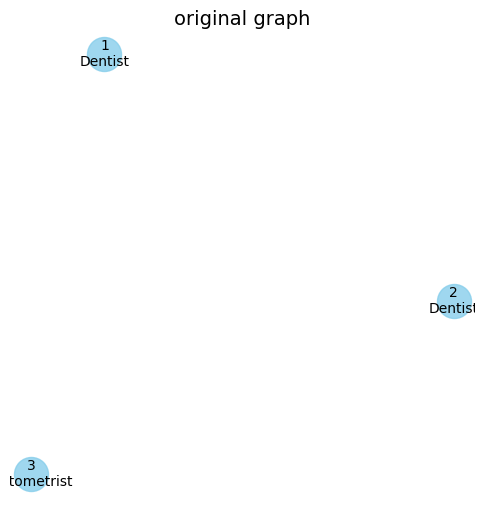

------------------------------
VertexList:  [3, 2, 1]
K:  3
candidate_set:  [2, 1]
SeedVertex:  3
Number of components node 3: 0
Number of components node 2: 0
Number of components node 3: 0
Number of components node 1: 0


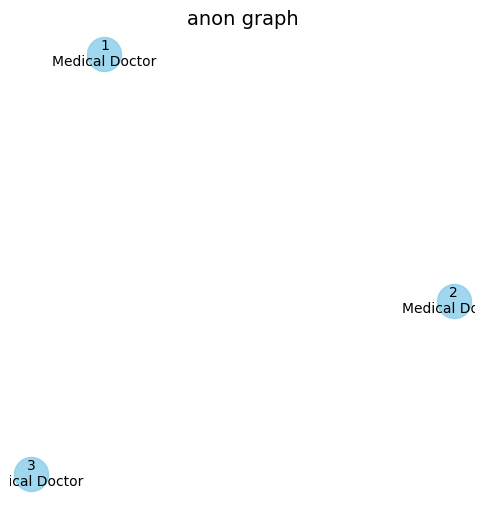

In [218]:
disconneted_G = nx.Graph()
disconneted_G.add_nodes_from([1, 2, 3])
disconneted_G = assign_randomly_leaf_labels(disconneted_G, label_domain, seed = 42)
plot_component(disconneted_G, "original graph")
G_anon = anonymize_graph(disconneted_G, 3, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

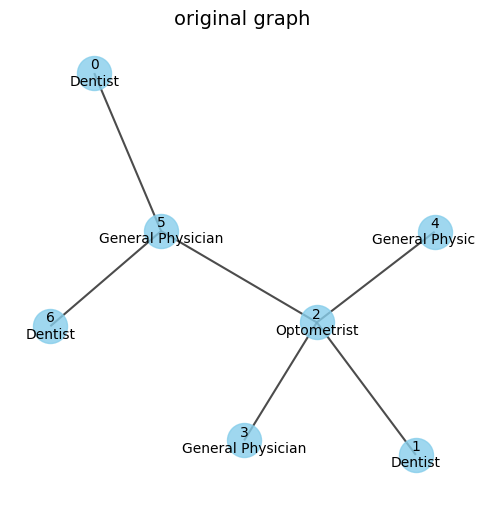

------------------------------
VertexList:  [2, 5, 6, 4, 3, 1, 0]
K:  2
candidate_set:  [5]
SeedVertex:  2
Number of components node 2: 4
Number of components node 5: 3
1 perfect component match!
Matched: [1] - [0]
Finding a match for node 5
Built constraints: {5}
New vertex found in build_component: 0 matching 5
node_map_1_2:  {5: 0}
------------------------------
VertexList:  [6, 4, 3, 1, 0]
K:  2
candidate_set:  [4]
SeedVertex:  6
Number of components node 6: 1
Number of components node 4: 1
1 perfect component match!
Matched: [5] - [2]
------------------------------
VertexList:  [3, 1, 0]
K:  2
candidate_set:  [1, 0]
SeedVertex:  3
Number of components node 3: 1
Number of components node 1: 1
1 perfect component match!
Matched: [2] - [2]
Number of components node 3: 1
Number of components node 0: 1
1 perfect component match!
Matched: [2] - [5]


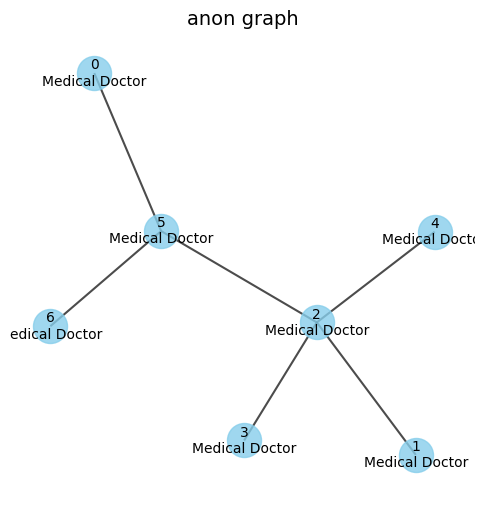

In [219]:
two_stars_G = nx.Graph()
two_stars_G.add_nodes_from([0, 1, 2, 3, 4, 5, 6])
two_stars_G.add_edges_from([(1, 2), (3, 2), (4, 2), (2, 5), (5, 6), (5, 0)]) 

two_stars_G = assign_randomly_leaf_labels(two_stars_G, label_domain, seed = 42)
plot_component(two_stars_G, "original graph")
G_anon = anonymize_graph(two_stars_G, 2, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")
#iso_classes = check_isomorphic_classes(G_anon, equivalence_dict)
#print("Isomorphic subgraph groups:")
#for group in iso_classes:
#    print(group)

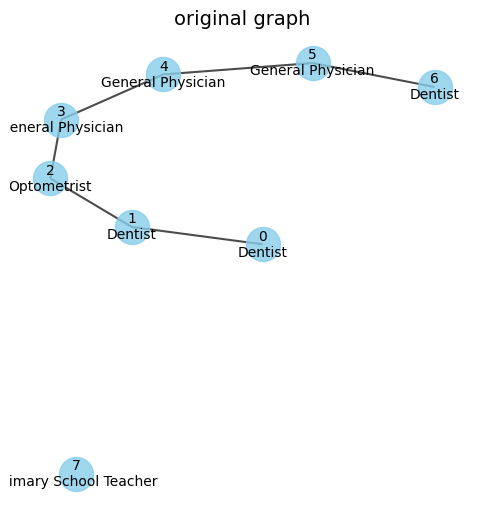

------------------------------
VertexList:  [5, 4, 3, 2, 1, 6, 0, 7]
K:  2
candidate_set:  [4]
SeedVertex:  5
Number of components node 5: 2
Number of components node 4: 2
1 perfect component match!
Matched: [4] - [3]
------------------------------
VertexList:  [3, 2, 1, 6, 0, 7]
K:  2
candidate_set:  [2]
SeedVertex:  3
Number of components node 3: 2
Number of components node 2: 2
1 perfect component match!
Matched: [4] - [3]
------------------------------
VertexList:  [1, 6, 0, 7]
K:  2
candidate_set:  [6]
SeedVertex:  1
Number of components node 1: 2
Number of components node 6: 1
1 perfect component match!
Matched: [2] - [5]
Finding a match for node 0
Built constraints: {6}
New vertex found in build_component: 7 matching 0
node_map_1_2:  {0: 7}
------------------------------
VertexList:  [7, 0]
K:  2
candidate_set:  [0]
SeedVertex:  7
Number of components node 7: 1
Number of components node 0: 1
1 perfect component match!
Matched: [6] - [1]


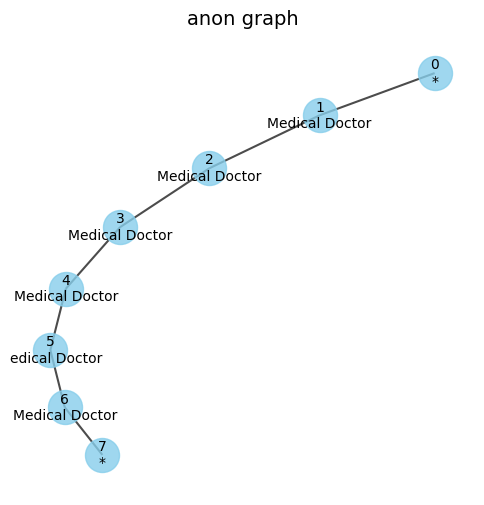

In [220]:
pentagon_G = nx.Graph()
pentagon_G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7])
pentagon_G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]) 

pentagon_G = assign_randomly_leaf_labels(pentagon_G, label_domain, seed = 42)
plot_component(pentagon_G, "original graph")
G_anon = anonymize_graph(pentagon_G, 2, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")
#iso_classes = check_isomorphic_classes(G_anon, equivalence_dict)
#print("Isomorphic subgraph groups:")
#for group in iso_classes:
#    print(group)

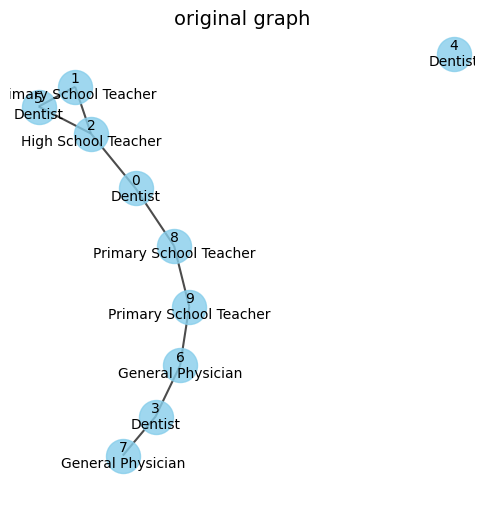

------------------------------
VertexList:  [2, 5, 1, 9, 8, 6, 3, 0, 7, 4]
K:  2
candidate_set:  [1]
SeedVertex:  2
Number of components node 2: 2
Number of components node 1: 1
Finding a match for node 0
Built constraints: {1}
New vertex found in build_component: 4 matching 0
node_map_1_2:  {0: 4}
------------------------------
VertexList:  [5, 9, 8, 6, 3, 0, 7, 4]
K:  2
candidate_set:  [3]
SeedVertex:  5
Number of components node 5: 1
Number of components node 3: 2
Finding a match for node 7
Built constraints: {5}
New vertex found in build_component: 7 matching 7
node_map_1_2:  {7: 7}
Ripple: Breaking group of 1
------------------------------
VertexList:  [6, 4, 2, 1, 9, 8, 7, 0]
K:  2
candidate_set:  [4]
SeedVertex:  6
Number of components node 6: 2
Number of components node 4: 2
1 perfect component match!
Matched: [3, 4] - [3, 6]
------------------------------
VertexList:  [2, 1, 9, 8, 7, 0]
K:  2
candidate_set:  [1]
SeedVertex:  2
Number of components node 2: 2
Number of component

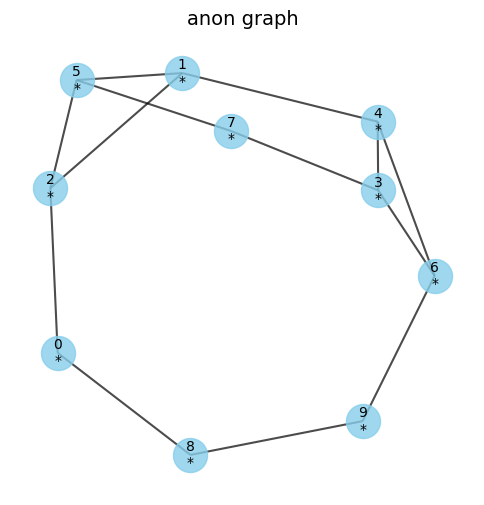

In [221]:
G_random = nx.gnp_random_graph(n=10, p=0.1, seed=42)
G_random = assign_randomly_leaf_labels(G_random, label_domain)
plot_component(G_random, "original graph")
G_anon = anonymize_graph(G_random, 2, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

In [222]:
nx.density(G_anon)

0.28888888888888886

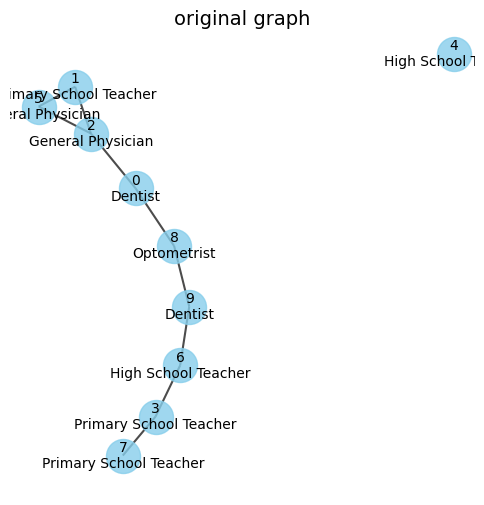

------------------------------
VertexList:  [2, 5, 1, 9, 8, 6, 3, 0, 7, 4]
K:  3
candidate_set:  [5, 9]
SeedVertex:  2
Number of components node 2: 2
Number of components node 5: 1
1 perfect component match!
Matched: [1, 5] - [1, 2]
Finding a match for node 0
Built constraints: {5}
New vertex found in build_component: 4 matching 0
node_map_1_2:  {0: 4}
Number of components node 2: 2
Number of components node 9: 2
------------------------------
VertexList:  [8, 7, 1, 6, 3, 0, 4]
K:  3
candidate_set:  [7, 1]
SeedVertex:  8
Number of components node 8: 2
Number of components node 7: 2
Ripple: Breaking group of 9
Number of components node 8: 2
Number of components node 1: 1
Finding a match for node 0
Built constraints: {1}
New vertex found in build_component: 4 matching 0
node_map_1_2:  {0: 4}
------------------------------
VertexList:  [5, 9, 2, 4, 6, 3, 0]
K:  3
candidate_set:  [9, 2]
SeedVertex:  5
Number of components node 5: 1
Number of components node 9: 2
Finding a match for node 6


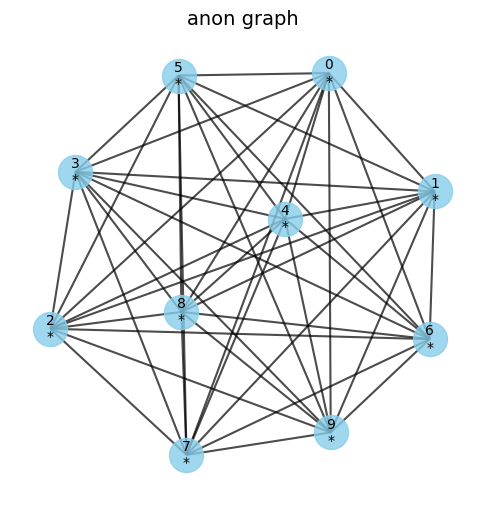

In [223]:
G_random = nx.gnp_random_graph(n=10, p=0.1, seed=42)
G_random = assign_randomly_leaf_labels(G_random, label_domain)
plot_component(G_random, "original graph")
G_anon = anonymize_graph(G_random, 3, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

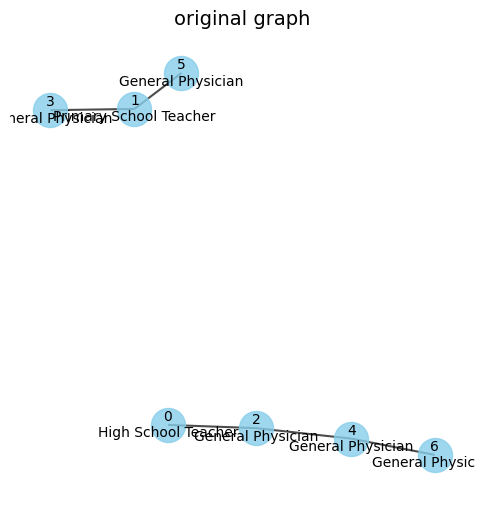

------------------------------
VertexList:  [4, 2, 1, 6, 5, 3, 0]
K:  2
candidate_set:  [2]
SeedVertex:  4
Number of components node 4: 2
Number of components node 2: 2
1 perfect component match!
Matched: [2] - [4]
------------------------------
VertexList:  [1, 6, 5, 3, 0]
K:  2
candidate_set:  [6]
SeedVertex:  1
Number of components node 1: 2
Number of components node 6: 1
1 perfect component match!
Matched: [3] - [4]
Finding a match for node 5
Built constraints: {6}
New vertex found in build_component: 3 matching 5
node_map_1_2:  {5: 3}
------------------------------
VertexList:  [3, 5, 0]
K:  2
candidate_set:  [5, 0]
SeedVertex:  3
Number of components node 3: 2
Number of components node 5: 1
1 perfect component match!
Matched: [1] - [1]
Finding a match for node 6
Built constraints: {5}
New vertex found in build_component: 0 matching 6
node_map_1_2:  {6: 0}
Number of components node 3: 2
Number of components node 0: 2


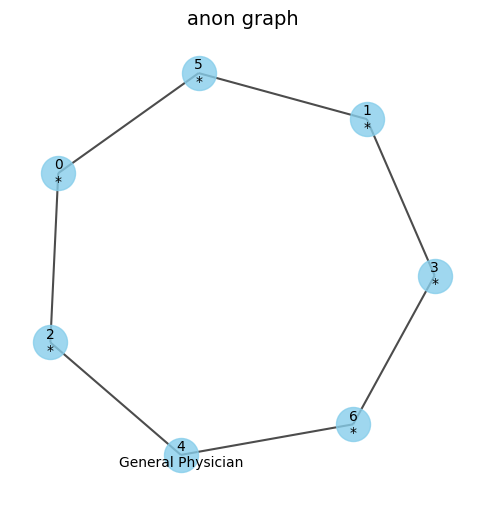

In [224]:
G_random = nx.gnp_random_graph(n=7, p=0.1, seed=42)
G_random = assign_randomly_leaf_labels(G_random, label_domain, seed=24)
plot_component(G_random, "original graph")
G_anon = anonymize_graph(G_random, 2, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

In [225]:
nx.density(G_anon)

0.3333333333333333

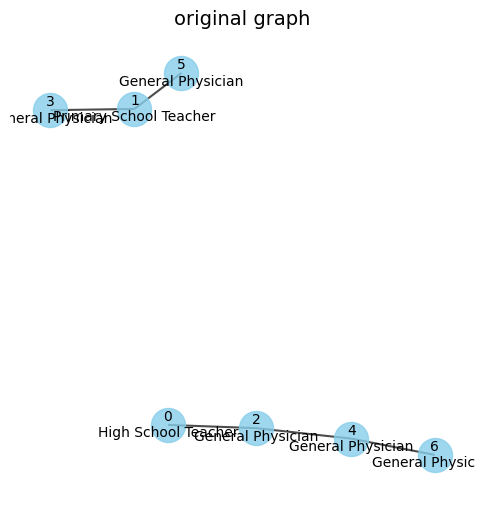

------------------------------
VertexList:  [4, 2, 1, 6, 5, 3, 0]
K:  3
candidate_set:  [2, 1]
SeedVertex:  4
Number of components node 4: 2
Number of components node 2: 2
1 perfect component match!
Matched: [2] - [4]
Number of components node 4: 2
Number of components node 1: 2
1 perfect component match!
Matched: [2] - [3]
------------------------------
VertexList:  [6, 5, 3, 0]
K:  3
candidate_set:  [5, 3, 0]
SeedVertex:  6
Number of components node 6: 1
Number of components node 5: 1
1 perfect component match!
Matched: [4] - [1]
Number of components node 6: 1
Number of components node 3: 1
1 perfect component match!
Matched: [4] - [1]
Number of components node 6: 1
Number of components node 0: 1
1 perfect component match!
Matched: [4] - [2]


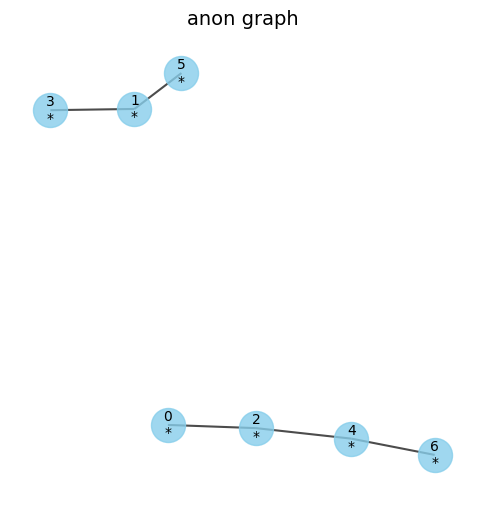

In [226]:
G_random = nx.gnp_random_graph(n=7, p=0.1, seed=42)
G_random = assign_randomly_leaf_labels(G_random, label_domain, seed=24)
plot_component(G_random, "original graph")
G_anon = anonymize_graph(G_random, 3, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

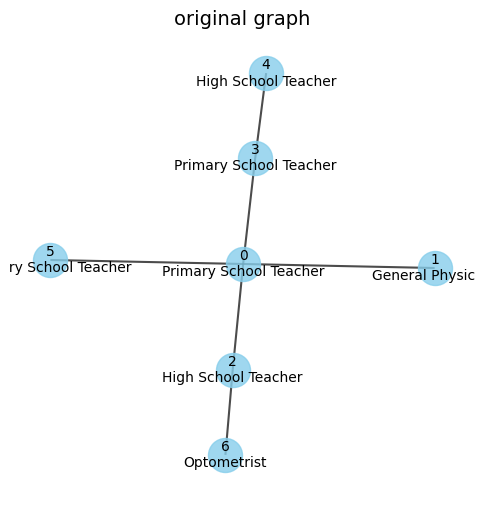

------------------------------
VertexList:  [0, 3, 2, 6, 5, 4, 1]
K:  2
candidate_set:  [3]
SeedVertex:  0
Number of components node 0: 4
Number of components node 3: 2
1 perfect component match!
Matched: [2] - [4]
1 perfect component match!
Matched: [3] - [0]
Finding a match for node 1
Built constraints: {3}
New vertex found in build_component: 1 matching 1
node_map_1_2:  {1: 1}
Finding a match for node 5
Built constraints: {3}
New vertex found in build_component: 5 matching 5
node_map_1_2:  {5: 5}
------------------------------
VertexList:  [5, 1, 2, 6, 4]
K:  2
candidate_set:  [2]
SeedVertex:  5
Number of components node 5: 1
Number of components node 2: 2
Finding a match for node 6
Built constraints: {5}
New vertex found in build_component: 6 matching 6
node_map_1_2:  {6: 6}
Ripple: Breaking group of 3
------------------------------
VertexList:  [0, 3, 4, 1, 6]
K:  2
candidate_set:  [3]
SeedVertex:  0
Number of components node 0: 1
Number of components node 3: 1
Ripple: Breaking gr

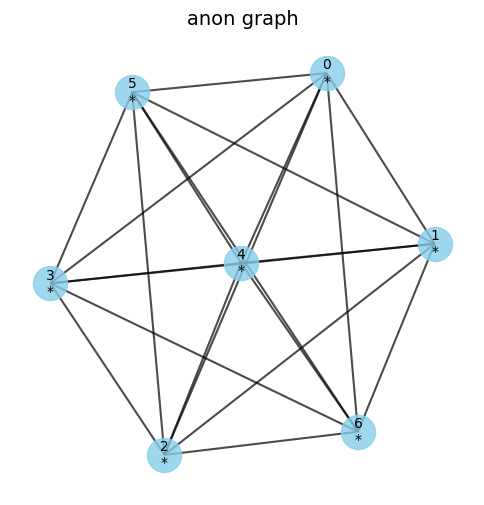

In [227]:
n= 7
m = 1
G_ba = nx.barabasi_albert_graph(n=n, m=m, seed=42)
G_ba = assign_randomly_leaf_labels(G_ba, label_domain, seed=53)
plot_component(G_ba, "original graph")
G_anon = anonymize_graph(G_ba, 2, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

In [228]:
nx.density(G_anon)

1.0

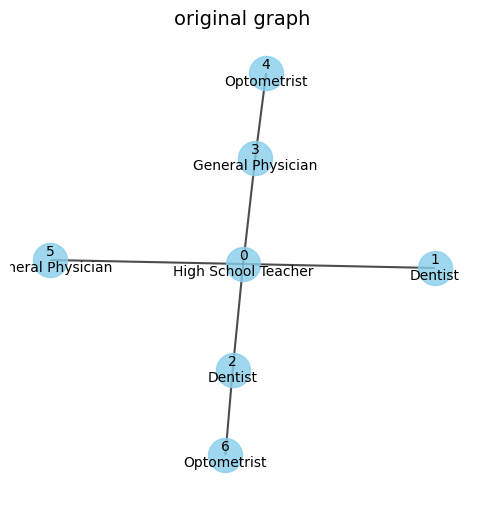

------------------------------
VertexList:  [0, 3, 2, 6, 5, 4, 1]
K:  3
candidate_set:  [3, 2]
SeedVertex:  0
Number of components node 0: 4
Number of components node 3: 2
Finding a match for node 3
Built constraints: {3}
New vertex found in build_component: 5 matching 3
node_map_1_2:  {3: 5}
Finding a match for node 5
Built constraints: {3}
New vertex found in build_component: 1 matching 5
node_map_1_2:  {5: 1}
Number of components node 0: 2
Number of components node 2: 2
1 perfect component match!
Matched: [2] - [0]
------------------------------
VertexList:  [4, 1, 6, 5]
K:  3
candidate_set:  [1, 6, 5]
SeedVertex:  4
Number of components node 4: 1
Number of components node 1: 1
Ripple: Breaking group of 2
Number of components node 4: 1
Number of components node 6: 1
Number of components node 4: 1
Number of components node 5: 1
1 perfect component match!
Matched: [0, 1, 2, 3, 5, 6] - [0, 1, 2, 3, 4, 6]
------------------------------
VertexList:  [3, 2, 0]
K:  3
candidate_set:  [2, 0]

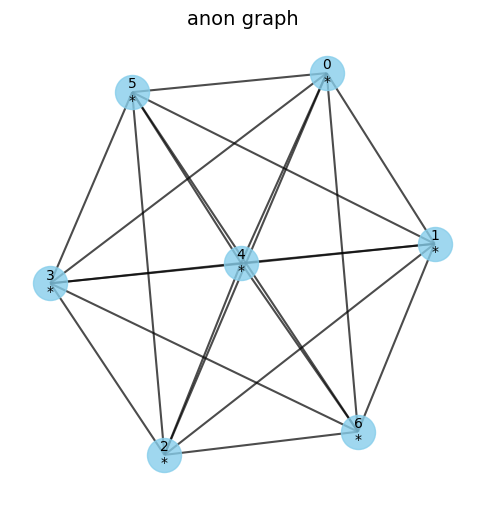

In [229]:
n= 7
m = 1
G_ba = nx.barabasi_albert_graph(n=n, m=m, seed=42)
G_ba = assign_randomly_leaf_labels(G_ba, label_domain)
plot_component(G_ba, "original graph")
G_anon = anonymize_graph(G_ba, 3, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

In [ ]:
nx.density(G_anon)

0.05877551020408163

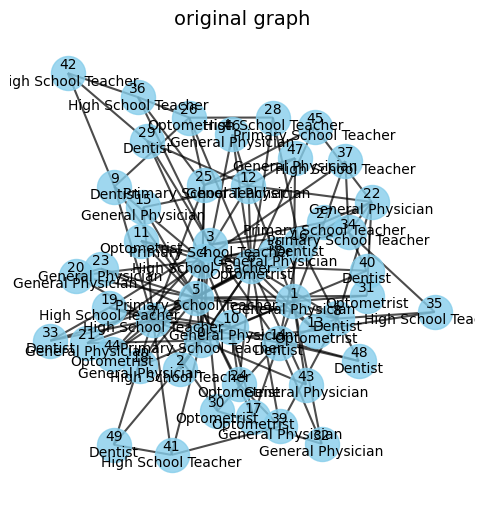

------------------------------
VertexList:  [5, 4, 7, 6, 0, 3, 14, 10, 1, 12, 25, 8, 22, 34, 16, 26, 9, 27, 41, 20, 39, 30, 29, 24, 19, 13, 36, 49, 43, 33, 21, 18, 11, 2, 48, 47, 46, 44, 38, 37, 32, 31, 28, 23, 15, 45, 42, 40, 35, 17]
K:  3
candidate_set:  [4, 7]
SeedVertex:  5
Number of components node 5: 2
Number of components node 4: 2
1 perfect component match!
Matched: [17] - [30]
Number of components node 5: 2
Number of components node 7: 2
------------------------------
VertexList:  [0, 6, 12, 25, 9, 20, 21, 41, 11, 3, 10, 15, 16, 2, 33, 14, 28, 1, 37, 43, 40, 30, 35, 18, 17, 23, 19, 44, 24, 34, 8, 22, 38, 32, 42, 49, 48, 26, 31, 27, 29, 39, 13, 36, 47, 46, 45]
K:  3
candidate_set:  [6, 12]
SeedVertex:  0
Number of components node 0: 1
Number of components node 6: 1
Ripple: Breaking group of 4
Number of components node 0: 1
Number of components node 12: 1
------------------------------
VertexList:  [7, 11, 2, 21, 24, 5, 20, 4, 28, 47, 15, 8, 33, 25, 9, 48, 44, 40, 27, 43, 3, 22,

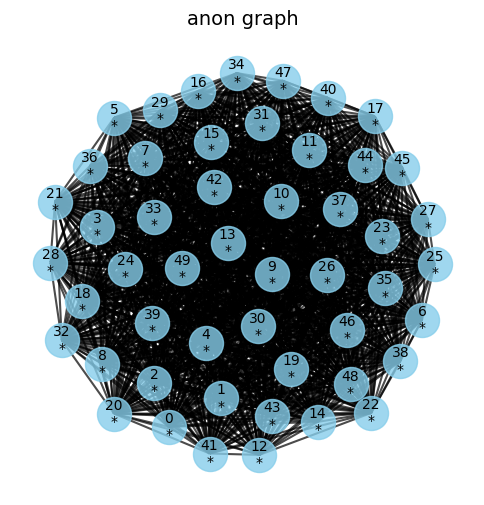

In [232]:
n= 50
m = 3
G_ba = nx.barabasi_albert_graph(n=n, m=m, seed=42)
G_ba = assign_randomly_leaf_labels(G_ba, label_domain, seed=53)
plot_component(G_ba, "original graph")
G_anon = anonymize_graph(G_ba, 3, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

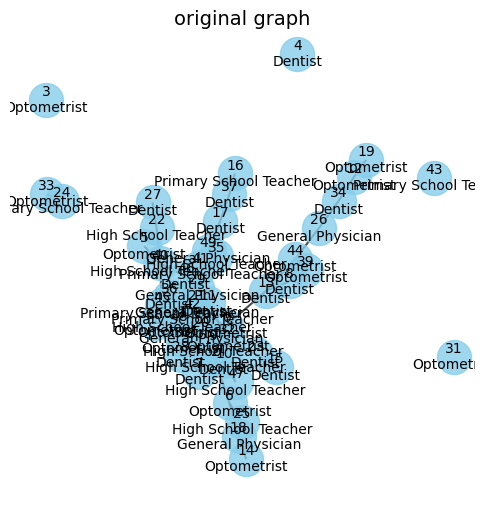

------------------------------
VertexList:  [29, 0, 11, 48, 40, 32, 20, 2, 49, 46, 45, 44, 42, 41, 30, 28, 13, 10, 6, 21, 39, 38, 37, 35, 34, 26, 23, 22, 18, 17, 12, 9, 8, 7, 1, 47, 36, 33, 27, 25, 24, 19, 16, 15, 14, 5, 43, 31, 4, 3]
K:  2
candidate_set:  [0]
SeedVertex:  29
Number of components node 29: 4
Number of components node 0: 5
1 perfect component match!
Matched: [41] - [42]
1 perfect component match!
Matched: [49] - [20]
Finding a match for node 2
Built constraints: {29}
New vertex found in build_component: 43 matching 2
node_map_1_2:  {2: 43}
------------------------------
VertexList:  [11, 10, 48, 40, 32, 20, 2, 49, 46, 45, 44, 42, 41, 30, 28, 13, 6, 21, 3, 39, 38, 37, 35, 34, 26, 23, 22, 18, 17, 12, 9, 8, 7, 1, 47, 43, 36, 33, 27, 25, 24, 19, 16, 15, 14, 5, 31, 4]
K:  2
candidate_set:  [10]
SeedVertex:  11
Number of components node 11: 3
Number of components node 10: 3
1 perfect component match!
Matched: [29, 21] - [0, 3]
1 perfect component match!
Matched: [46] - [7]
---

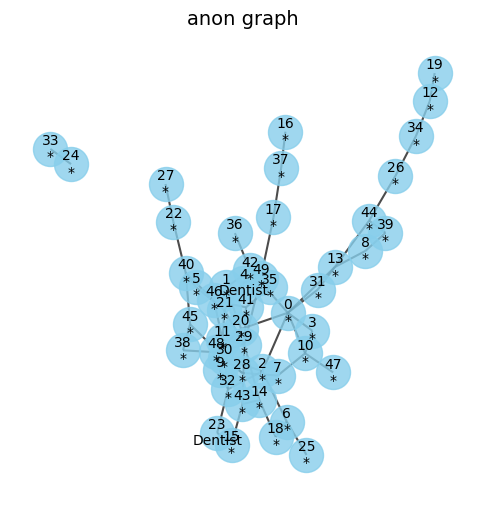

In [238]:
G_random = nx.gnp_random_graph(n=50, p=0.05, seed=42)
G_random = assign_randomly_leaf_labels(G_random, label_domain, seed=45)
plot_component(G_random, "original graph")
G_anon = anonymize_graph(G_random, 2, label_domain, 10, 1, 1)
plot_component(G_anon, "anon graph")

In [239]:
nx.density(G_anon)

0.053877551020408164

In [240]:
nx.density(G_random)

0.044897959183673466

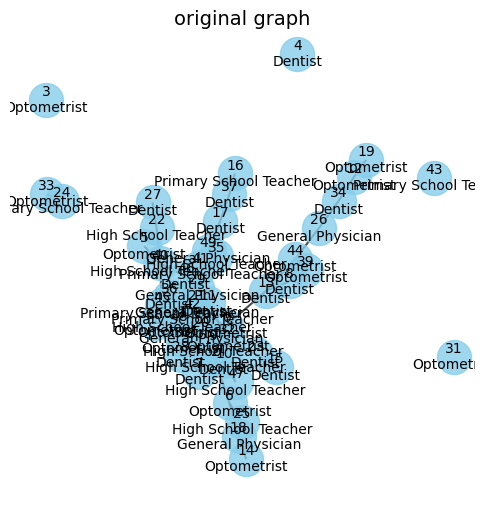

------------------------------
VertexList:  [29, 0, 11, 48, 40, 32, 20, 2, 49, 46, 45, 44, 42, 41, 30, 28, 13, 10, 6, 21, 39, 38, 37, 35, 34, 26, 23, 22, 18, 17, 12, 9, 8, 7, 1, 47, 36, 33, 27, 25, 24, 19, 16, 15, 14, 5, 43, 31, 4, 3]
K:  3
candidate_set:  [0, 20]
SeedVertex:  29
Number of components node 29: 4
Number of components node 0: 5
1 perfect component match!
Matched: [41] - [42]
1 perfect component match!
Matched: [49] - [20]
Finding a match for node 2
Built constraints: {29}
New vertex found in build_component: 43 matching 2
node_map_1_2:  {2: 43}
Number of components node 29: 5
Number of components node 20: 4
1 perfect component match!
Matched: [48] - [0]
Finding a match for node 49
Built constraints: {20}
New vertex found in build_component: 31 matching 49
node_map_1_2:  {49: 31}
------------------------------
VertexList:  [48, 11, 10, 40, 32, 2, 49, 46, 45, 44, 42, 41, 30, 28, 13, 6, 21, 4, 3, 39, 38, 37, 35, 34, 26, 23, 22, 18, 17, 12, 9, 8, 7, 1, 47, 43, 36, 33, 31, 27,

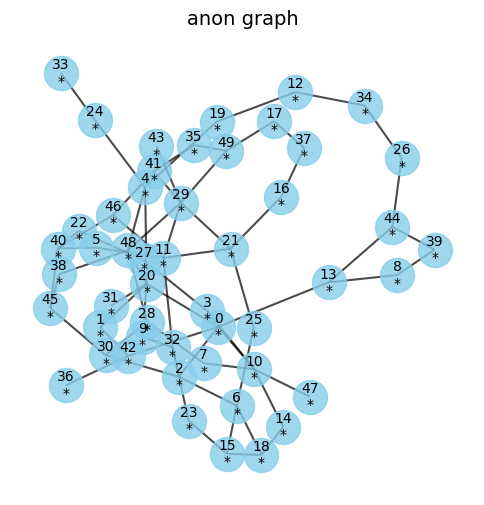

In [241]:
G_random = nx.gnp_random_graph(n=50, p=0.05, seed=42)
G_random = assign_randomly_leaf_labels(G_random, label_domain, seed=45)
plot_component(G_random, "original graph")
G_anon = anonymize_graph(G_random, 3, label_domain, 10, 1, 1)
plot_component(G_anon, "anon graph")

In [242]:
nx.density(G_anon)

0.05714285714285714

In [243]:
nx.density(G_random)

0.044897959183673466